In [347]:
#Code Prototype for 1D use on EXCLAIM Project, code by Joaquin Matticoli

In [348]:
import numpy as np
import filterpy
#from filterpy.kalman import KalmanFilter as kf
#from filterpy.kalman import predict
#from filterpy.kalman import update
from numpy.random import randn
from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
import filterpy.stats as stats
import math
from math import sqrt

In [349]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

def print_gh(predict, update, z, scale):
    predict_template = '{: 7.3f} {: 8.3f}'
    update_template = '{:.3f}\t{: 7.3f} {: 7.3f}    {:.3f}'

    print(predict_template.format(predict[0], predict[1]),end='\t')
    print(update_template.format(z, update[0], update[1], scale))
    
def predict(posterior, movement): #inputed as gaussians
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

def update(prior, measurement, check=0): #inputed as gaussians
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
       
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain
       
    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    
    if check==0:
        return gaussian(x, P)
    else:
        return K

In [350]:
class PayloadSimulation(object):
    def __init__(self, x0=0, angular_velocity=1,
                 measurement_var=0.0,
                 process_var=0.0):
        """ x0 : initial orientation
            angular_velocity: (+=counterclockwise, -=clockwise)
            measurement_var: variance in measurement deg^2
            process_var: variance in process (deg/s)^2
        """
        self.x = x0
        self.angular_velocity = angular_velocity
        self.meas_std = sqrt(measurement_var)
        self.process_std = sqrt(process_var)

    def move(self, dt=1.0):
        """Compute new orientation of the payload in dt seconds."""
        dx = self.angular_velocity + abs(randn()*self.process_std)
        self.x += dx * dt

    def sense_position(self):
        """ Returns measurement of new orientation in degrees."""
        measurement = self.x + abs(randn()*self.meas_std)
        return measurement

    def move_and_sense(self):
        """ Move payload, and return measurement of new orientation in degrees"""
        self.move()
        return self.sense_position()

In [351]:
printcase = 1 # If set to 1 it will print out the results
plotcase = 1 # If set to 1 it will plot results

#-----------USER INPUT STARTS------------------------------

process_var = 25. # variance in the payload's movement, idk what number is good for this??
sensor_var = 16. # variance in the sensor
x = gaussian(0., 100.)  # payload's orientation in deg
angular_velocity = 0.5 # angular velocity in deg/s
dt = 1 # time step in seconds
n_iter = 75 # Number of measurements that the sensor will take

#-----------USER INPUT ENDS--------------------------------

process_model = gaussian(angular_velocity*dt, process_var) # displacement to add to x

    #NOTE: sensor variance is in velocity as it measures that so be careful when creating code for that as it's different to other codes
    #NOTE: this code will assume that orientation is always increasing/decreasing and not sinusodial because a more complext Kalman filter is needed for those cases
    
# simulate payload and get measurements
payload = PayloadSimulation(
    x0=x.mean, 
    angular_velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# creates list of measurements, NOTE: modify this section if measurements are provided
zs, ztrue = [], []
# ztrue = np.zeros(n_iter)
# zs = np.zeros(n_iter)
for _ in range(n_iter):
    zs.append(payload.move_and_sense())
    ztrue.append(payload.x)
finalposition = payload.x

PREDICT			UPDATE
     x      var		  z	    x      var	    K
  0.500  125.000	12.729	 11.342  14.184    0.887
 11.842   39.184	15.215	 14.237  11.361    0.710
 14.737   36.361	21.395	 19.360  11.111    0.694
 19.860   36.111	32.660	 28.730  11.087    0.693
 29.230   36.087	40.334	 36.923  11.085    0.693
 37.423   36.085	47.148	 44.161  11.085    0.693
 44.661   36.085	49.974	 48.342  11.085    0.693
 48.842   36.085	53.694	 52.203  11.085    0.693
 52.703   36.085	64.937	 61.179  11.085    0.693
 61.679   36.085	62.976	 62.578  11.085    0.693
 63.078   36.085	68.746	 67.005  11.085    0.693
 67.505   36.085	76.436	 73.692  11.085    0.693
 74.192   36.085	82.249	 79.774  11.085    0.693
 80.274   36.085	84.340	 83.091  11.085    0.693
 83.591   36.085	94.653	 91.255  11.085    0.693
 91.755   36.085	92.098	 91.993  11.085    0.693
 92.493   36.085	95.426	 94.525  11.085    0.693
 95.025   36.085	102.704	 100.345  11.085    0.693
 100.845   36.085	106.650	 104.866  11.085    0.693
 105.

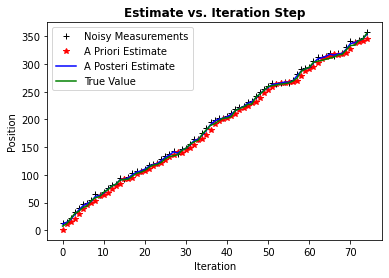

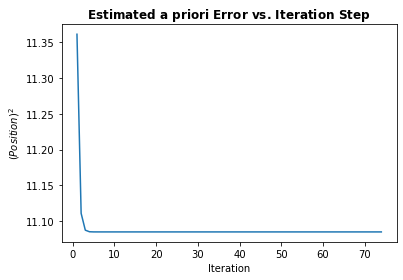

In [352]:
def plotstuff():
    plt.figure()
    plt.plot(zs,'k+',label='Noisy Measurements')
    plt.plot(x1,'r*',label='A Priori Estimate')
    plt.plot(xhat,'b-',label='A Posteri Estimate')
    plt.plot(ztrue,color='g',label='True Value')
    #plt.plot(xhat,'r*',label='prediction')
    plt.legend()
    plt.title('Estimate vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('Position')
    
    plt.figure()
    valid_iter = range(1,n_iter) # Pminus not valid at step 0
    plt.plot(valid_iter,Pminus[valid_iter],label='A Posteri Error Estimate')
    plt.title('Estimated $\it{\mathbf{a \ priori}}$ Error vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('$(Position)^2$')
    #plt.setp(plt.gca(),'ylim',[0,.01])
    plt.show()

x1 = np.zeros(n_iter)
#x2 = np.zeros(n_iter)
Pminus = np.zeros(n_iter)
xhat = np.zeros(n_iter)
counter = 0
if printcase == 1:
    print('PREDICT\t\t\tUPDATE')
    print('     x      var\t\t  z\t    x      var\t    K')
# perform Kalman filter on measurement z
for z in zs:    
    prior = predict(x, process_model)
    x1[counter] = prior.mean
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
    K1 = update(prior, likelihood, check=1)
    xhat[counter] = x.mean
    Pminus[counter] = x.var
    counter = counter + 1
    if printcase == 1:
        print_gh(prior, x, z, K1)

if printcase == 1:
    print()
    print('final estimate:           {:10.3f}'.format(x.mean))
    print('actual final orientation: {:10.3f}'.format(payload.x))
if plotcase == 1:
    plotstuff()